In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time
import numpy as np

In [52]:
from ML.lr import linear_regression 
from help_function import cal_mean_squared_error
from help_function import cal_directional_accuracy
from help_function import cal_Tolerance_Based_accuracy



In [53]:
# Load the dataset
train_file_path = "./datasets/Train_Pre_Processed_Dataset.csv"  # Replace with the path to your CSV file
train_data = pd.read_csv(train_file_path)

test_file_path = "./datasets/Test_Pre_Processed_Dataset.csv"  # Replace with the path to your CSV file
test_data = pd.read_csv(test_file_path)


In [54]:
#Define levels
levels=5

# Parse relevant columns for all bid and ask levels
bid_columns = [f"bids[{i}].price" for i in range(levels)] + [f"bids[{i}].amount" for i in range(levels)]
ask_columns = [f"asks[{i}].price" for i in range(levels)] + [f"asks[{i}].amount" for i in range(levels)]
feature_columns = bid_columns  + ask_columns
target_columns=['next_1st_mark_price','next_2nd_mark_price']
eval_columns=target_columns+ ["mark_price",'1st_Price_Movement',"1st_actual_direction",'2nd_Price_Movement',"2nd_actual_direction"]

# Features and target
X_train = train_data[feature_columns]
y_train = train_data[target_columns]
X_test = test_data[feature_columns]
y_test = test_data[eval_columns]
# X_eval = eval_data[feature_columns]

# y_eval = eval_data[eval_columns]

In [55]:
linear_regression=linear_regression(X_train,y_train,X_test)

In [56]:
# if not yet trained
# linear_regression.train()

In [57]:
# Predict 
# Measure the execution time of the function
start_time = time.time()
result=linear_regression.predict()
end_time = time.time()
execution_time = (end_time - start_time)* 1000 
print(f"Execution_time(Linear Regression): {execution_time:.2f} milliseconds")

Execution_time(Linear Regression): 74.13 milliseconds


In [69]:
eval_np_array= np.array(y_test[['next_1st_mark_price','next_2nd_mark_price',"1st_actual_direction","2nd_actual_direction"]])
# eval_np_array

In [59]:
# Evaluate performance using MSE on evaluation set
mse_lr = cal_mean_squared_error(eval_np_array[:,0:2], result)
print(f"MSE (Linear Regression): {mse_lr}")

MSE (Linear Regression): [13.16849905 11.11130075]


In [60]:
# Calculate directional accuracy
result_sign = np.sign(result - eval_np_array[:,0:2])
# directional_accuracy_lr = (Evaluate_result["actual_direction"] == Evaluate_result["predicted_direction_lr"]).mean()
directional_accuracy_lr=cal_directional_accuracy(eval_np_array[:,2:4],result_sign)
print(f"Directional Accuracy (Linear Regression): {directional_accuracy_lr}")

Directional Accuracy (Linear Regression): [0.28705633 0.53551312]


In [61]:
# Tolerance-Based Accuracy
# tolerance = 0.0001 * Evaluate_result["next_mark_price"].mean()  # Set tolerance to 0.01% of average price
# Evaluate_result.loc[:, "tolerance_lr"] = abs(Evaluate_result["predicted_lr"] - Evaluate_result["next_mark_price"]) <= tolerance

# Calculate tolerance-based accuracy
# tolerance_accuracy_lr = Evaluate_result["tolerance_lr"].mean()
tolerance_accuracy_lr = cal_Tolerance_Based_accuracy(eval_np_array[:,0:2], result)
print(f"Tolerance-Based Accuracy (Linear Regression): {tolerance_accuracy_lr}")

Tolerance-Based Accuracy (Linear Regression): [0.90766782 0.92195216]


In [62]:
linear_regression_Predict_data=pd.DataFrame({"predicted_next_1st_mark_price":result[:,0], 
                                             "predicted_next_2nd_mark_price":result[:,1],
                                            })

In [63]:
linear_regression_Performance=pd.DataFrame({"model": "linear_regression",
                                            "1st_mark_price_mse_lr": mse_lr[0],
                                             "1st_mark_price_tolerance_accuracy_lr": tolerance_accuracy_lr[0],
                                             "1st_mark_price_directional_accuracy_lr": directional_accuracy_lr[0],      
                                             "2nd_mark_price_mse_lr": mse_lr[1],
                                             "2nd_mark_price_tolerance_accuracy_lr": tolerance_accuracy_lr[1],
                                             "2nd_mark_price_directional_accuracy_lr": directional_accuracy_lr[1],
                                             "execution_time":execution_time}, index=[0])

In [64]:
Evaluate_result=pd.concat([y_test, linear_regression_Predict_data], axis=1)

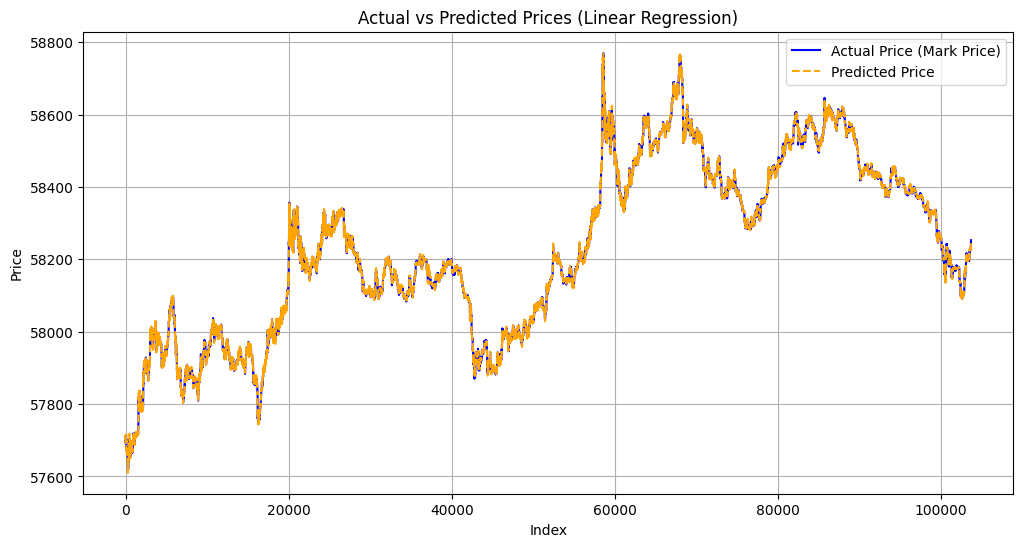

In [65]:
# Visualize the actual vs. predicted price along with signals
plt.figure(figsize=(12, 6))
plt.plot(Evaluate_result["next_1st_mark_price"], label="Actual Price (Mark Price)", color="blue")
plt.plot(Evaluate_result["predicted_next_1st_mark_price"], label="Predicted Price", color="orange", linestyle="--")
plt.title("Actual vs Predicted Prices (Linear Regression)")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


In [66]:
# Removed Based on our model is regression problem
# # Add symbol columns based on comparison with the last mark price
# symbol_tolerance = 0.0001 * eval_data["next_mark_price"].mean()  # Adjust as needed
# Evaluate_result.loc[:, "symbol_lr"] = None

# for i in range(len(Evaluate_result)):

#     # Linear Regression symbol logic
#     if Evaluate_result["predicted_lr"].iloc[i] > Evaluate_result["mark_price"].iloc[i] + symbol_tolerance:
#         Evaluate_result.loc[Evaluate_result.index[i], "symbol_lr"] = "up"
#     elif Evaluate_result["predicted_lr"].iloc[i] < Evaluate_result["mark_price"].iloc[i] - symbol_tolerance:
#         Evaluate_result.loc[Evaluate_result.index[i], "symbol_lr"] = "down"
#     else:
#         Evaluate_result.loc[Evaluate_result.index[i], "symbol_lr"] = "stable"

# # Visualize symbol distributions
# symbol_counts_lr = Evaluate_result["symbol_lr"].value_counts()
# Actual_signal_counts = Evaluate_result["Price Movement"].value_counts()

# lr_predict_values = symbol_counts_lr.values.tolist()
# actual_values = Actual_signal_counts.values.tolist()

# labels = Actual_signal_counts.index.tolist()

# # Setting the positions and width for the bars
# positions = np.arange(len(labels))
# bar_width = 0.35


# # Create the bar plot
# bar1=plt.bar(positions, lr_predict_values, bar_width, label='Predicted Signal', color='b', alpha=0.7)
# bar2=plt.bar(positions + bar_width, actual_values, bar_width, label='Actual Signal', color='orange', alpha=0.7)

# # Adding labels, title, and legend
# plt.xlabel('Labels')
# plt.ylabel('Counts')
# plt.title('Predicted vs Actual Signal Counts (Linear Regression)')
# plt.xticks(positions + bar_width / 2, labels)
# plt.legend()

# # Displaying the values on top of each bar
# for bar in bar1 + bar2:
#     height = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')


# plt.show()